Our method consist of three different models: 
1) Unsupervised model (All the celltypes are unknown)
2) Supervised model (Some of the celltypes are known)
3) Semi-supervised model (Multiple batches (>2) with celltypes in one batch are unavaliable)

In this notebook, we applied our TNN model on four pancreas datasets generated with different platforms. The bulk of the analysis will be based on the AnnData and Seurat-like scanpy tutorial, with embeddings slotting into the adata.obsm['X_tnn']. We'll make use of embeddings visualisation as Umap by constructing its 2-dimension reduction.

Please noting that if you would to re-run the code, you may get slightly differing visuals, but the overall findings should still hold. 

The pancreas data used in this notebook can be found in https://github.com/lkmklsmn/bbtnn/Dataset. 

In [1]:
from bbtnn.tnn_v3 import BBTNN
import scanpy as sc
import numpy as np
import pandas as pd


/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Random Forest Classifier
from sklearn import metrics
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
    model.fit(train_x, train_y)
    return model

In [3]:
adata = sc.read("/Users/ywang59/Dropbox/19_16_Lukas_DeepLearning_ongoing/scData/Merge_filter.h5")
adata

AnnData object with n_obs × n_vars = 13275 × 15562 
    obs: 'Celltypes', 'batch'

In [4]:
sc.pp.recipe_zheng17(adata, n_top_genes=3000)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs = 50)
sc.tl.umap(adata)

# Unupervised model (Cell label unavailable)

In [32]:
%%time
bbtnn_unsupervised = BBTNN(k=50, distance='pn', batch_size=64, n_epochs_without_progress=10, approx= False, k_to_m_ratio=0.5)
bbtnn_unsupervised.fit(X = adata, Y = None, batch_name='batch')


version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
6450 cells defined as MNNs
Calculating KNNs...
3225 cells defined as KNNs
Total cells for training:8088
Reorder
Training neural network
Epoch 1/1000
127/127 [==============================] - 2s 19ms/step - loss: 1.2218
Epoch 2/1000
127/127 [==============================] - 1s 6ms/step - loss: 0.6705
Epoch 3/1000
127/127 [==============================] - 1s 6ms/step - loss: 0.5183
Epoch 4/1000
127/127 [==============================] - 1s 7ms/step - loss: 0.4443
Epoch 5/1000
127/127 [==============================] - 1s 6ms/step - loss: 0.3920
Epoch 6/1000
127/127 [==============================] - 1s 6ms/step - loss: 0.3558
Epoch 7/1000
127/127 [==============================] - 1s 7ms/step - loss: 0.3291
Epoch 8/1000
127/127 [==============================] - 1s 6ms/step - loss: 0.3

13275/13275 [==============================] - 1s 44us/sample


/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


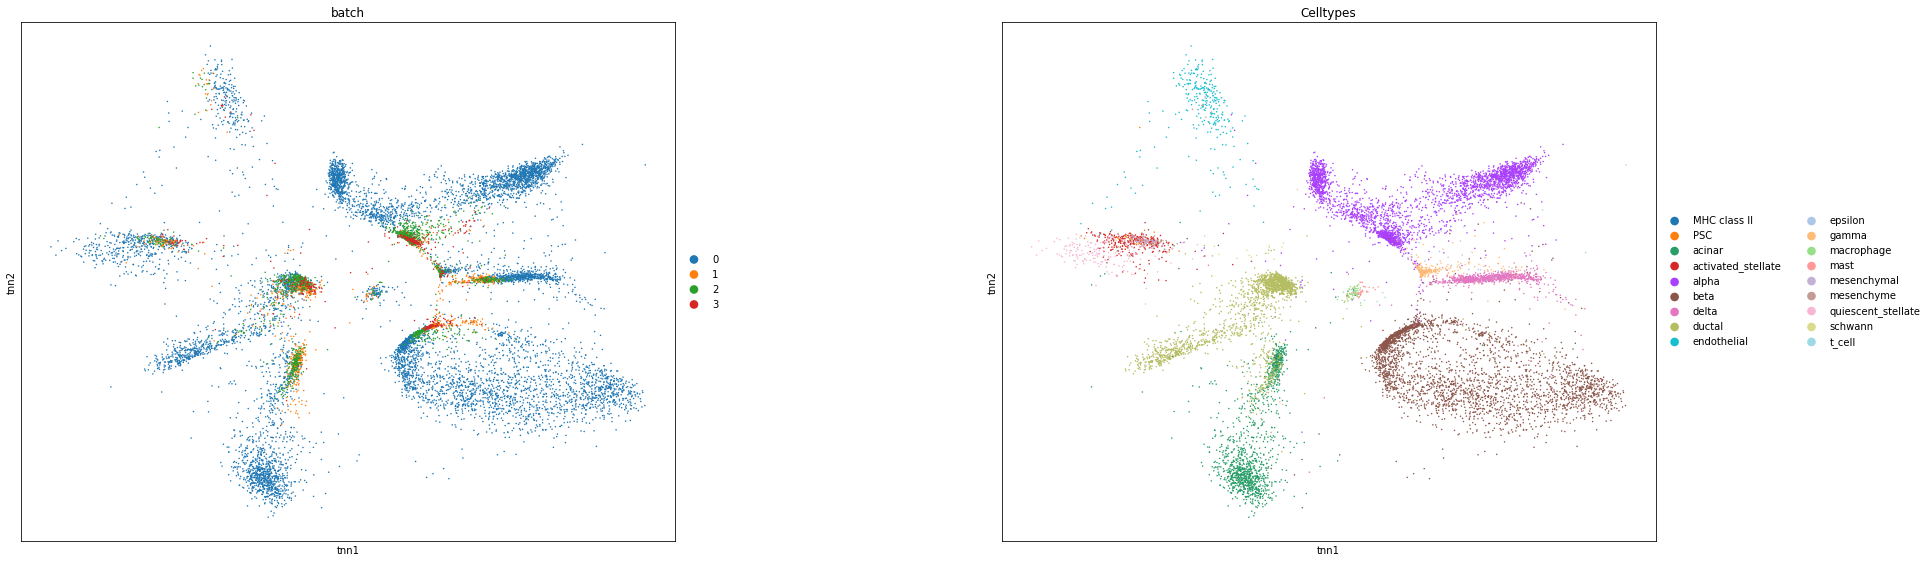

In [33]:
embeddings = bbtnn_unsupervised.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis = 'tnn', color = ['batch','Celltypes'])


In [34]:
embeddings = bbtnn_unsupervised.transform(adata)
adata.obsm['X_tnn'] = embeddings
accuracy_batch = []
batch_list = adata.obs['batch'].unique()
for batch in batch_list:       
    train_x = adata.obsm['X_tnn'][adata.obs['batch']!=batch]
    train_y = adata.obs['Celltypes'][adata.obs['batch']!=batch]

    test_x = adata.obsm['X_tnn'][adata.obs['batch']==batch]
    test_y = adata.obs['Celltypes'][adata.obs['batch']==batch]

    model = random_forest_classifier(train_x, train_y)

    predict = model.predict(test_x)
    accuracy = metrics.accuracy_score(test_y, predict)
    print ('accuracy: %.2f%%' % (100 * accuracy))
    accuracy_batch.append(accuracy)


13275/13275 [==============================] - 0s 27us/sample
accuracy: 75.67%
accuracy: 70.08%
accuracy: 72.87%
accuracy: 82.28%


## Compared with BBKNN

In [24]:
import bbknn
adata_bbknn_trim = bbknn.bbknn(adata, neighbors_within_batch=5, n_pcs=50, trim=50, copy=True)
sc.tl.umap(adata_bbknn_trim)

sc.pl.umap(adata_bbknn_trim, color=['batch','Celltypes'], save='BBKNN_trim_TNN_update.pdf')

/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


## Compared with scanorama

In [8]:
from datetime import timedelta
import scanorama

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [9]:
adatas = []
adatas.append([adata[adata.obs['batch']==i] for i in adata.obs['batch'].unique()])
Integrated, Corrected = scanorama.correct_scanpy(adatas[0], return_dimred=True)
celltypelist = []
for i in range(len(adatas[0])):
    celltypelist += adatas[0][i].obs['Celltypes'].tolist()

batchlist = []
for i in range(len(adatas[0])):
    batchlist += adatas[0][i].obs['batch'].tolist()

Corrected_Data = Corrected[0].concatenate(Corrected[1:], join='inner')
Corrected_Data.obs['Celltypes'] = celltypelist
Corrected_Data.obs['batch'] = batchlist

sc.pp.neighbors(Corrected_Data,n_neighbors=30)
sc.tl.umap(Corrected_Data)

Found 2999 genes among all datasets
[[0.         0.39585297 0.04607428 0.00437637]
 [0.         0.         0.50801131 0.02407002]
 [0.         0.         0.         0.66958425]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (0, 1)
         Falling back to preprocessing with `sc.pp.pca` and default params.


/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


In [23]:

sc.pl.umap(Corrected_Data, color=['batch','Celltypes'], wspace = 0.2, size=20, legend_fontsize=16,legend_fontweight='bold', save = 'scanorama_TNN_update.pdf')


/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


## Compared with Harmony

In [11]:
pca = adata.obsm['X_pca']
batch = adata.obs['batch']

In [12]:
%load_ext rpy2.ipython

/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [13]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)


hem <- HarmonyMatrix(pca, batch, theta=4)
hem = data.frame(hem)



Error in library(harmony) : there is no package called ‘harmony’


/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in library(harmony) : there is no package called ‘harmony’

  warnings.warn(x, RRuntimeWarning)


In [ ]:
adata.obsm['X_pca'] = hem.values
sc.pp.neighbors(adata,n_neighbors=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch','celltype'])

# Supervised model

In [14]:
bbtnn_supervised = BBTNN(k=50, distance='pn', batch_size=64, n_epochs_without_progress=10, approx= False)
bbtnn_supervised.fit(X = adata, Y = None, batch_name='batch', celltype_name='Celltypes', cell_labeled = True)


version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
6450 cells defined as MNNs
Generating supervised positive pairs...
[0, 1, 2, 3]
Categories (4, object): [0, 1, 2, 3]
4
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (0, 3)
Processing positive pairs (1, 2)
Processing positive pairs (1, 3)
Processing positive pairs (2, 3)
9694 cells defined as supervision triplets
4462
Calculating KNNs...
3870 cells defined as KNNs
Total cells for training:12455
Reorder
Training neural network
Epoch 1/1000
195/195 [==============================] - 4s 18ms/step - loss: 1.2694
Epoch 2/1000
195/195 [==============================] - 1s 7ms/step - loss: 0.6994
Epoch 3/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.5504
Epoch 4/1000
195/195 [==============================] - 1s 6ms/step - lo

195/195 [==============================] - 1s 6ms/step - loss: 0.2414
Epoch 91/1000
195/195 [==============================] - 1s 7ms/step - loss: 0.2523
Epoch 92/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2495
Epoch 93/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2496
Epoch 94/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2562
Epoch 95/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2509
Epoch 96/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2506
Epoch 97/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2480
Epoch 98/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2542
Epoch 99/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2489
Epoch 100/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2377
Epoch 101/1000
195/195 [==============================] - 1s 6ms/step - loss: 0.2535
Epoc

BBTNN(annoy_index_path=None, approx=False, batch_size=64,
      build_index_on_disk=True, callbacks=[], distance='pn', embedding_dims=2,
      epochs=1000, k=50, k_to_m_ratio=0.6, label_ratio=0.8, margin=1,
      n_epochs_without_progress=10, ntrees=50, precompute=True,
      save_on_disk=True, search_k=-1,
      supervision_metric='sparse_categorical_crossentropy',
      supervision_weight=0.3, verbose=1)

In [22]:
embeddings = bbtnn_supervised.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis = 'tnn', color = ['batch','Celltypes'], size=20, legend_fontsize = 20, save='TNN_update_pancreas_supervsied.pdf')

13275/13275 [==============================] - 0s 28us/sample


/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


In [17]:
embeddings = bbtnn_supervised.transform(adata)
adata.obsm['X_tnn'] = embeddings
accuracy_batch = []
batch_list = adata.obs['batch'].unique()
for batch in batch_list:       
    train_x = adata.obsm['X_tnn'][adata.obs['batch']!=batch]
    train_y = adata.obs['Celltypes'][adata.obs['batch']!=batch]

    test_x = adata.obsm['X_tnn'][adata.obs['batch']==batch]
    test_y = adata.obs['Celltypes'][adata.obs['batch']==batch]

    model = random_forest_classifier(train_x, train_y)

    predict = model.predict(test_x)
    accuracy = metrics.accuracy_score(test_y, predict)
    print ('accuracy: %.2f%%' % (100 * accuracy))
    accuracy_batch.append(accuracy)


13275/13275 [==============================] - 0s 34us/sample
accuracy: 88.48%
accuracy: 92.13%
accuracy: 94.88%
accuracy: 93.44%


In [20]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters= len(list(adata.obs['Celltypes'].unique()))
X = bbtnn_unsupervised.transform(adata)
cluster_labels = adata.obs['Celltypes'].tolist()
silhouette_avg_unsupervised = silhouette_score(X, cluster_labels)
print (silhouette_avg_unsupervised)

13275/13275 [==============================] - 0s 29us/sample
0.14523359


In [21]:
X = bbtnn_supervised.transform(adata)
cluster_labels = adata.obs['Celltypes'].tolist()
silhouette_avg_supervised = silhouette_score(X, cluster_labels)
print (silhouette_avg_supervised)

13275/13275 [==============================] - 0s 26us/sample
0.6571914


Supervised model will significantly increaset the silhouette coefficient score of the clusters.

Unsupervised_model: Silhouette score = 0.14523359
Supervised_model: Silhouette score = 0.6571914

# Semi-supervised model

## Specific example (Each celltypes occurs in at least two batch)

version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5411 cells defined as MNNs
Generating supervised positive pairs...
[0, 1, 2]
Categories (3, object): [0, 1, 2]
3
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (1, 2)
8063 cells defined as supervision triplets
3065
Calculating KNNs...
3247 cells defined as KNNs
Total cells for training:11326
Reorder
Training neural network
Epoch 1/1000
177/177 [==============================] - 3s 15ms/step - loss: 1.1345
Epoch 2/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.5948
Epoch 3/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.5104
Epoch 4/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.4450
Epoch 5/1000
177/177 [==============================] - 1s 6ms/step - loss: 0.4214
Epoch 6/100

/anaconda3/lib/python3.7/site-packages/scanpy/plotting/_utils.py:312: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


accuracy: 83.59%


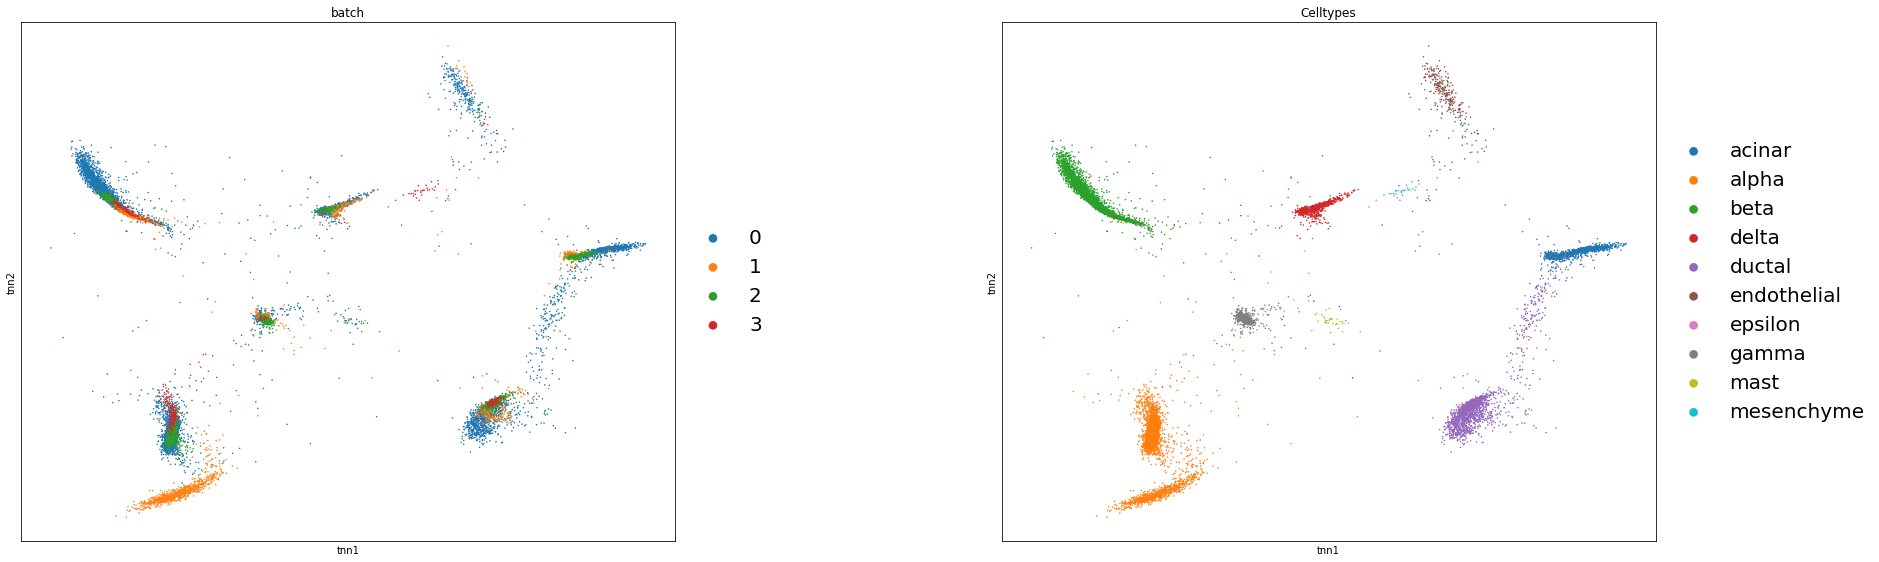

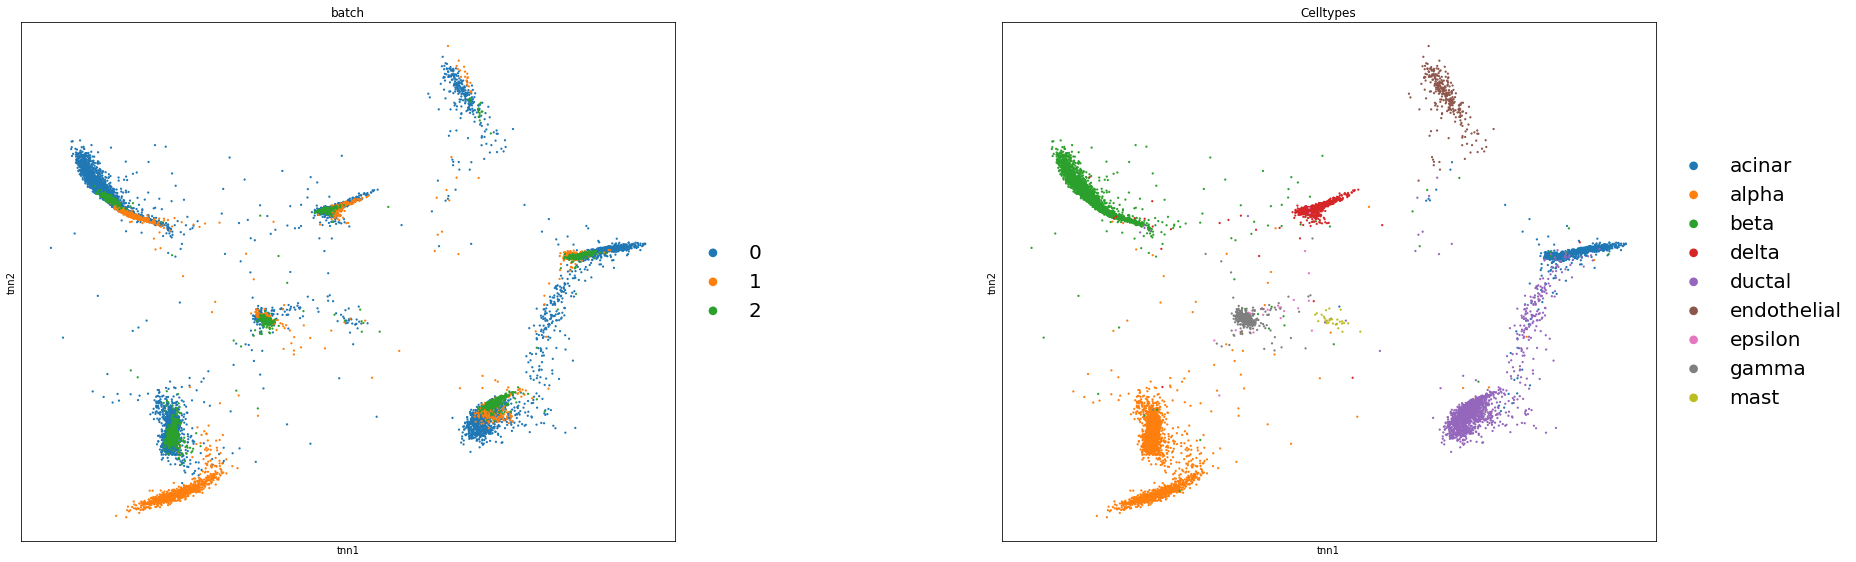

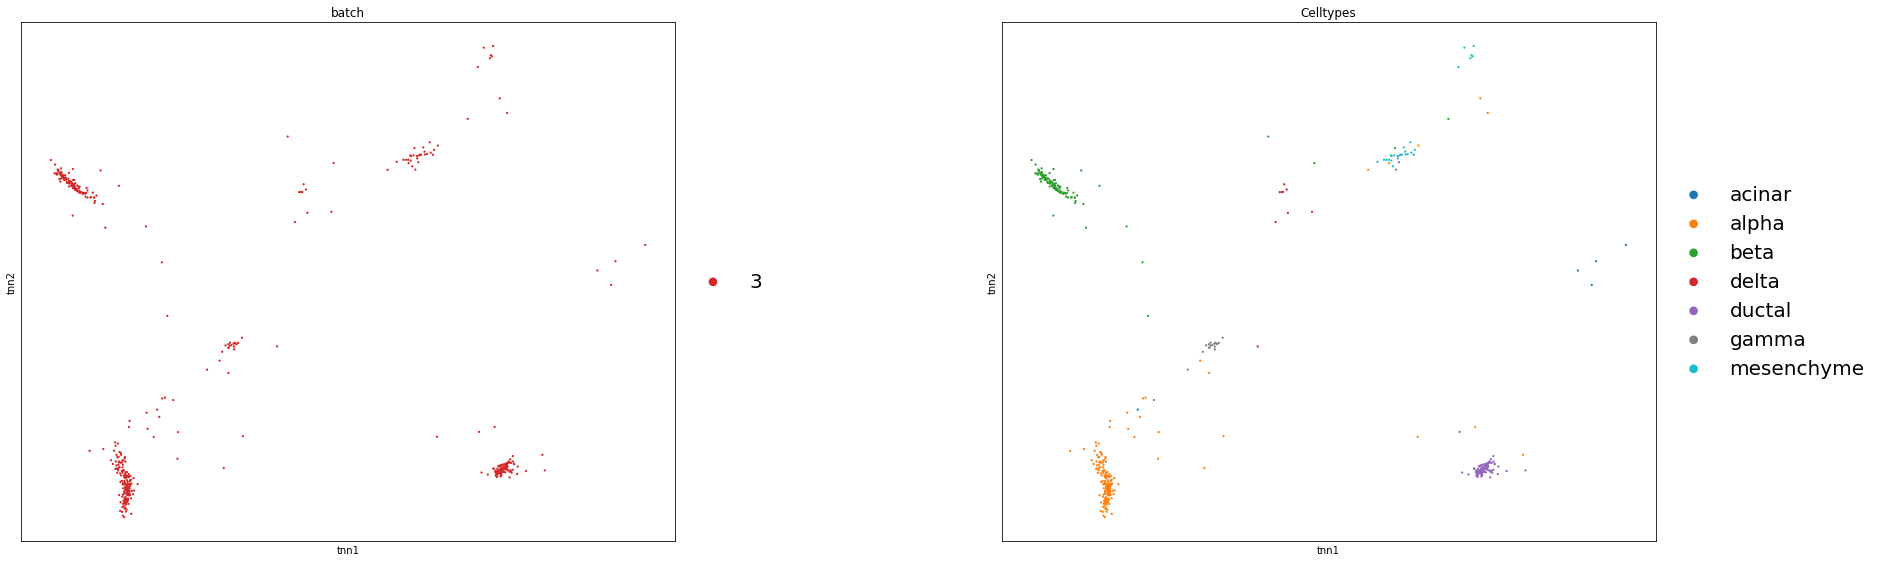

In [35]:
adata = sc.read("/Users/ywang59/Dropbox/19_16_Lukas_DeepLearning_ongoing/scData/Merge_common.h5")
batch_list = adata.obs['batch'].unique()

       
bbtnn_semi_supervised = BBTNN(k=50, distance='pn', batch_size=64, n_epochs_without_progress=10, approx=False)
bbtnn_semi_supervised.fit(X = adata, Y = None, batch_name='batch', celltype_name='Celltypes', cell_labeled=True, mask_batch= batch)
embeddings = bbtnn_semi_supervised.transform(adata)
adata.obsm['X_tnn'] = embeddings
sc.pl.scatter(adata, basis = 'tnn', color = ['batch','Celltypes'], legend_fontsize = 20, )
sc.pl.scatter(adata[adata.obs['batch']!=batch], basis = 'tnn', color = ['batch','Celltypes'], size = 20, legend_fontsize = 20,)
sc.pl.scatter(adata[adata.obs['batch']==batch], basis = 'tnn', color = ['batch','Celltypes'], size = 20, legend_fontsize = 20,)

train_x = adata.obsm['X_tnn'][adata.obs['batch']!=batch]
train_y = adata.obs['Celltypes'][adata.obs['batch']!=batch]

test_x = adata.obsm['X_tnn'][adata.obs['batch']==batch]
test_y = adata.obs['Celltypes'][adata.obs['batch']==batch]

model = random_forest_classifier(train_x, train_y)

predict = model.predict(test_x)
accuracy = metrics.accuracy_score(test_y, predict)
print ('accuracy: %.2f%%' % (100 * accuracy))


## Common example 

In real dataset, not all the batches consist of same number of celltypes. This should be a common issue.

In [69]:
bdata = adata[adata.obs['batch']!=2]
bdata = bdata [bdata.obs['Celltypes']!='gamma']
cdata = adata[adata.obs['batch']=='2']
ddata = bdata.concatenate(cdata)
ddata.obs['Batch']  = list(bdata.obs['batch']) + list(cdata.obs['batch'])


In [70]:
%%time
bbtnn_test = BBTNN(k=50, distance='pn', batch_size=64, n_epochs_without_progress=10,label_ratio=0.8, k_to_m_ratio=0.75)
bbtnn_test.fit(X = ddata, Y = None, batch_name='Batch', celltype_name='Celltypes', cell_labeled=True,  mask_batch= '2')



version 02.04. 21:30
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5709 cells defined as MNNs
Generating supervised positive pairs...
['0' '1' '3']
3
Processing positive pairs (0, 1)
Processing positive pairs (0, 2)
Processing positive pairs (1, 2)
7739 cells defined as supervision triplets
2734
Calculating KNNs...
4282 cells defined as KNNs
Total cells for training:12285
Reorder
Training neural network
Epoch 1/1000
192/192 [==============================] - 6s 30ms/step - loss: 1.0790
Epoch 2/1000
192/192 [==============================] - 1s 6ms/step - loss: 0.6282
Epoch 3/1000
192/192 [==============================] - 1s 7ms/step - loss: 0.5115
Epoch 4/1000
192/192 [==============================] - 1s 7ms/step - loss: 0.4585
Epoch 5/1000
192/192 [==============================] - 1s 7ms/step - loss: 0.4210
Epoch 6/1000
192/192 [===================

14101/14101 [==============================] - 2s 130us/sample


... storing 'Celltypes' as categorical
... storing 'Batch' as categorical


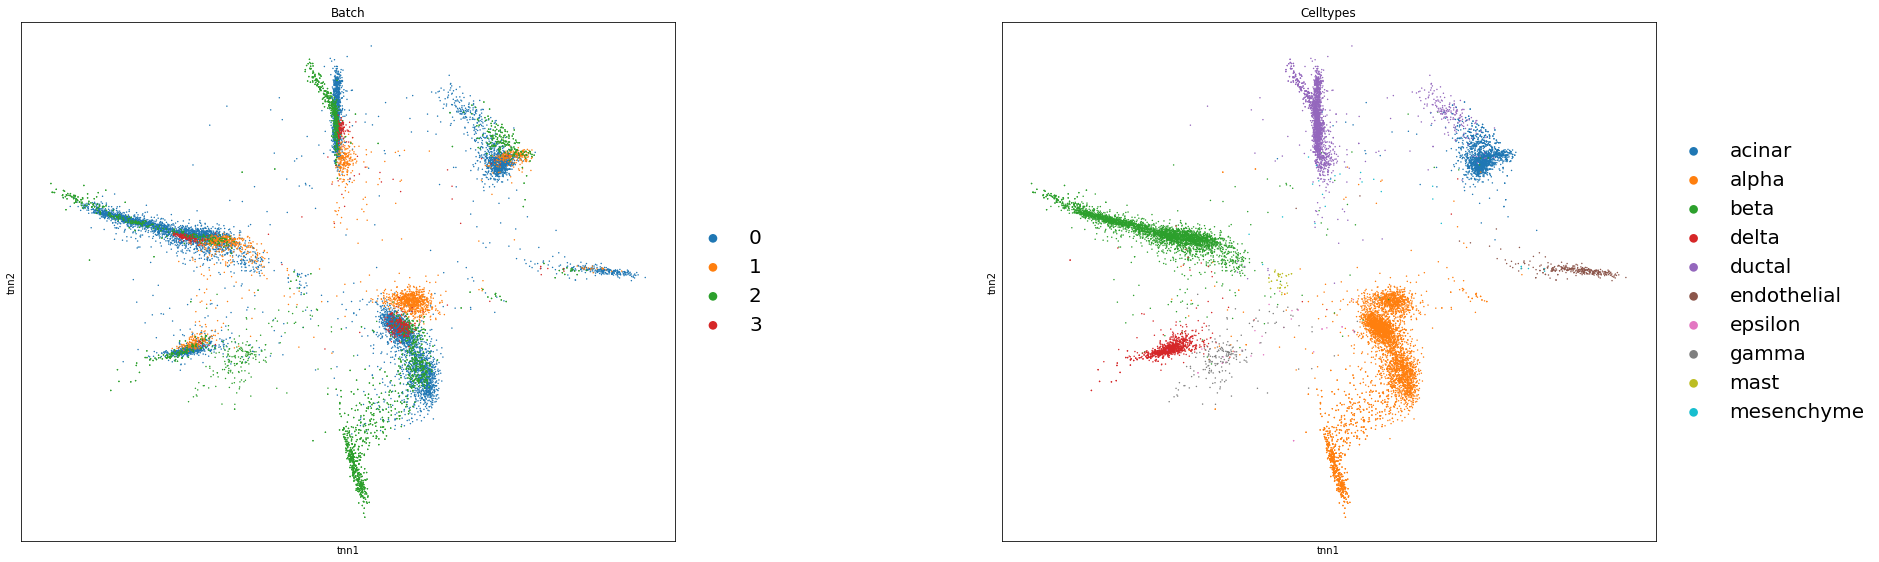

In [71]:
embeddings = bbtnn_test.transform(ddata)
ddata.obsm['X_tnn'] = embeddings
sc.pl.scatter(ddata, basis = 'tnn', color = ['Batch','Celltypes'], legend_fontsize = 20, )
